# Relationship Between Police Calls And Price of M²

### 1. Import Packages

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
from geopandas.tools import sjoin
import re
import shapely
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from shapely.geometry import Polygon
from shapely.geometry import Point
import sys

### 2. Graphics

In [2]:
%matplotlib inline
sns.set()

### 3. Read the Data

In [3]:
regions = pd.read_csv("./data/regions.csv", dtype={"number" : "str"},sep=",")
calls = pd.read_csv("./data/policecalls.csv", dtype={"number" : "str"},sep=",")

### 4. Pre-processing

In [4]:
calls["lat"] = calls.lat.apply(pd.to_numeric, args=('coerce',))
calls["lng"] = calls.lng.apply(pd.to_numeric, args=('coerce',))

In [5]:
for num in range(0, len(regions)):
    data = regions.THE_GEOM[num].replace('POLYGON ((', '').replace('))', '').strip()
    res = []
    for rec in data.split(', '):
        res.append(tuple(float(val) for val in rec.split()))
    poly = Polygon(res)
    regions["THE_GEOM"][num] = poly


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [6]:
calls["geometry"] = calls.apply(lambda z: Point(z.lng, z.lat), axis=1)
regions["geometry"] = gpd.GeoSeries(regions["THE_GEOM"])
calls_gdf = gpd.GeoDataFrame(calls)
regions_gdf = gpd.GeoDataFrame(regions)
calls_gdf.crs
regions_gdf.crs
calls_gdf.crs = {"init": "epsg:4326"}
regions_gdf.crs = {"init": "epsg:4326"}
calls_gdf = calls_gdf[calls_gdf.is_valid == True]

### 5. Columns Of Interest

In [7]:
columns_of_interest = ["NOME", "VAL_M2_RES", "AREA", "geometry"]
regions_gdf = regions_gdf[columns_of_interest]
regions_gdf.columns = ["BAIRRO", "VAL_M2_RES", "AREA", "geometry"]
columns_of_interest = ["date", "geometry"]
calls_gdf = calls_gdf[columns_of_interest]
calls_gdf.columns = ["DATA", "geometry"]

### 6. Visualize Dada

In [8]:
calls_gdf.head(1)

,DATA,geometry
0,2005-01-01,POINT (-38.5554 -3.73784)


In [9]:
regions_gdf.head(1)

,BAIRRO,VAL_M2_RES,AREA,geometry
0,PASSARE,2424.77,7167306.57,POLYGON ((-38.53981906785994 -3.79553710684326...


### 7. Merge Data Frames

In [10]:
merged_gdf = gpd.sjoin(calls_gdf, regions_gdf, how="inner", op="intersects")

### 8. Visualize Merged Data Frame

In [11]:
merged_gdf.head()

,DATA,geometry,index_right,BAIRRO,VAL_M2_RES,AREA
0,2005-01-01,POINT (-38.5554 -3.73784),116,PARQUELANDIA,2509.18,1253555.18
211,2005-01-04,POINT (-38.5592 -3.73552),116,PARQUELANDIA,2509.18,1253555.18
303,2005-01-05,POINT (-38.5553 -3.73816),116,PARQUELANDIA,2509.18,1253555.18
444,2005-01-07,POINT (-38.567 -3.73716),116,PARQUELANDIA,2509.18,1253555.18
527,2005-01-08,POINT (-38.5662 -3.74159),116,PARQUELANDIA,2509.18,1253555.18


### 9. Group Data Frame

In [12]:
grouped_gdf = merged_gdf.groupby(["BAIRRO"]).agg({'geometry': "count",
                                    'VAL_M2_RES': "mean",
                                    'AREA': "mean"})

In [13]:
grouped_gdf.columns = ["NUM_CALLS", "VAL_M2_RES", "AREA"]

In [14]:
grouped_gdf.head()

,NUM_CALLS,VAL_M2_RES,AREA
BAIRRO,,,
AEROLANDIA,651,1886.07,1096167.58
AEROPORTO,366,2126.39,6126648.09
ALDEOTA,4135,3193.62,3880855.37
ALTO DA BALANCA,1210,1784.38,916449.74
ALVARO WEYNE,1615,1954.28,1427008.93


In [15]:
grouped_gdf["CALLS_BY_M2"] = grouped_gdf["NUM_CALLS"] / grouped_gdf["AREA"]

In [16]:
grouped_gdf.head()

,NUM_CALLS,VAL_M2_RES,AREA,CALLS_BY_M2
BAIRRO,,,,
AEROLANDIA,651,1886.07,1096167.58,0.000594
AEROPORTO,366,2126.39,6126648.09,0.000060
ALDEOTA,4135,3193.62,3880855.37,0.001065
ALTO DA BALANCA,1210,1784.38,916449.74,0.001320
ALVARO WEYNE,1615,1954.28,1427008.93,0.001132


### 10. Visualize the new dataset

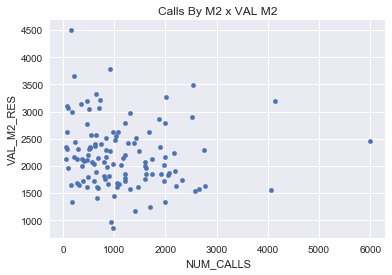

In [18]:
grouped_gdf.plot(kind = "scatter", 
                  x = "NUM_CALLS", y = "VAL_M2_RES", 
                  title = "Calls By M2 x VAL M2")
plt.show()

In [22]:
X = np.c_[grouped_gdf["NUM_CALLS"]]
y = np.c_[grouped_gdf["VAL_M2_RES"]]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [28]:
lr_model = linear_model.LinearRegression()

In [29]:
# train the model
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
y_train_pred = lr_model.predict(X_train)

In [33]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_train

367330.90654333576

In [34]:
r2_train = r2_score(y_train, y_train_pred)
r2_train

0.015386030158232367

In [35]:
print("Mean Squared Error = %.2f" % mse_train)

Mean Squared Error = 367330.91


In [36]:
print("Variance score = %.2f" % r2_train)

Variance score = 0.02


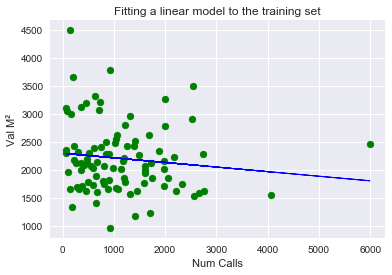

In [37]:
plt.scatter(X_train, y_train, color = "green")
plt.plot(X_train, y_train_pred, color = "blue", linewidth = 1)
plt.title("Fitting a linear model to the training set")
plt.xlabel("Num Calls")
plt.ylabel("Val M²")
plt.show()

In [61]:
polyf = PolynomialFeatures(10) # of second order, quadratic
X_train_f = polyf.fit_transform(X_train)

In [62]:
lrf_model = linear_model.LinearRegression()
lrf_model.fit(X_train_f, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [63]:
y_train_f_pred = lrf_model.predict(X_train_f)

In [64]:
mse_f_train = mean_squared_error(y_train, y_train_f_pred)
mse_f_train

366714.44142234465

In [65]:
r2_f_train = r2_score(y_train, y_train_f_pred)
r2_f_train

0.017038437182078647

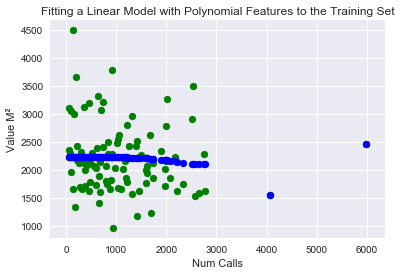

In [66]:
plt.scatter(X_train, y_train, color = "green")
plt.scatter(X_train_f[:,1], y_train_f_pred, color = "blue")
plt.title("Fitting a Linear Model with Polynomial Features to the Training Set")
plt.xlabel("Num Calls")
plt.ylabel("Value M²")
plt.show()